In [26]:
from keras.datasets.cifar10 import load_data
from keras.models import Sequential,load_model
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import Adam
from matplotlib import pyplot
import numpy as np

In [2]:
(X_train,Y_train),(X_test,Y_test) = load_data()
print("shapes of test are ",X_train.shape,Y_train.shape)
print("shapes of test are ",X_test.shape,Y_test.shape)

170500096/170498071 [==============================] - 3s 0us/step
shapes of test are  (50000, 32, 32, 3) (50000, 1)
shapes of test are  (10000, 32, 32, 3) (10000, 1)


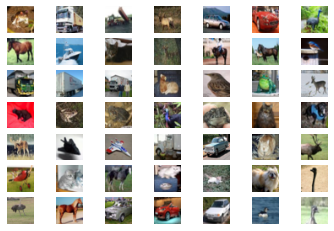

In [3]:
for i in range(49):
  pyplot.subplot(7, 7, 1 + i)
  pyplot.axis('off')
  pyplot.imshow(X_train[i])
pyplot.show()

In [4]:
def discriminatorModel(dims=(32,32,3)):
  model =Sequential()
  model.add(Conv2D(64,kernel_size=(3,3),padding='same',kernel_initializer="he_uniform",input_shape=dims))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer="he_uniform"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer="he_uniform"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(256,kernel_size=(3,3),strides=(2,2),padding='same',kernel_initializer="he_uniform"))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation='sigmoid'))

  opt=Adam(lr=0.0002,beta_1=0.5)
  model.compile(loss="binary_crossentropy",optimizer=opt,metrics=['accuracy'])
  return model

In [5]:
model=discriminatorModel()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [6]:
def load_real_samples():
  (X_train,_),(_,_)=load_data()
  X=X_train.astype('float32')
  X=(X-127.5)/127.5
  return X

In [7]:
def generate_real_samples(dataset,n_samples):
  ix=np.random.randint(0,dataset.shape[0],n_samples)
  X=dataset[ix]
  Y=np.ones((n_samples,1))
  return X,Y

In [8]:
def generate_temp_fake_samples(n_samples):
  X=np.random.rand(32*32*3*n_samples)
  X=-1+ (X*2)
  X=X.reshape((n_samples,32,32,3))
  Y=np.zeros((n_samples,1))
  return X,Y

In [9]:
def train_discriminator(model,dataset,n_iter=25,batch_size=128):
  half_batch=int(batch_size/2)
  for i in range(n_iter):
    X_real,Y_real=generate_real_samples(dataset,half_batch)
    _, real_acc = model.train_on_batch(X_real, Y_real)
    X_fake,Y_fake=generate_temp_fake_samples(half_batch)
    _, fake_acc = model.train_on_batch(X_fake, Y_fake)

    print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [10]:
model=discriminatorModel()
dataset=load_real_samples()
train_discriminator(model,dataset)

>1 real=25% fake=14%
>2 real=73% fake=34%
>3 real=73% fake=61%
>4 real=78% fake=72%
>5 real=66% fake=92%
>6 real=80% fake=89%
>7 real=78% fake=95%
>8 real=91% fake=92%
>9 real=92% fake=100%
>10 real=95% fake=98%
>11 real=91% fake=100%
>12 real=94% fake=100%
>13 real=98% fake=100%
>14 real=100% fake=100%
>15 real=92% fake=100%
>16 real=97% fake=100%
>17 real=98% fake=100%
>18 real=97% fake=100%
>19 real=100% fake=100%
>20 real=97% fake=100%
>21 real=98% fake=100%
>22 real=100% fake=100%
>23 real=98% fake=100%
>24 real=100% fake=100%
>25 real=98% fake=100%


## Generator Model

In [11]:
def generatorModel(latent_dim):
  model=Sequential()
  n_nodes=256*4*4
  model.add(Dense(n_nodes,input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
  # 8*8
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # 16*16
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  # 32*32
  model.add(Conv2DTranspose(128,(4,4),strides=(2,2),padding="same"))
  model.add(LeakyReLU(alpha=0.2))
  #32*32*3
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [12]:
latent_dim = 100
genmodel=generatorModel(latent_dim)
genmodel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         524416    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 128)      

In [13]:
def generate_latent_points(latent_dim,n_samples):
  X_input=np.random.randn(latent_dim*n_samples)
  X_input = X_input.reshape(n_samples, latent_dim)
  return X_input

In [14]:
def generate_fake_samples(generator,latent_dim,n_samples):
  X_input=generate_latent_points(latent_dim,n_samples)
  X=generator.predict(X_input)
  Y=np.zeros((n_samples,1))
  return X,Y

In [19]:
def define_gan(generator,discriminator):
  discriminator.trainable=False
  model=Sequential()
  model.add(generator)
  model.add(discriminator)
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt)
  return model

In [24]:
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()

In [16]:
def train(generator,discriminator,gan_model,dataset,latent_dim,n_epochs=200,n_batch=128):
  bat_per_epo=int(dataset.shape[0]/n_batch)
  half_batch=int(n_batch/2)
  for i in range(n_epochs):
    for j in range(bat_per_epo):
      X_real, y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch(X_real, y_real)
      X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
      X_gan = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch(X_gan, y_gan)
      print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [23]:
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	save_plot(x_fake, epoch)
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

In [25]:
latent_dim = 100
# create the discriminator
d_model = discriminatorModel()
# create the generator
g_model = generatorModel(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Streaming output truncated to the last 5000 lines.
>92, 241/390, d1=0.664, d2=0.588 g=0.972
>92, 242/390, d1=0.655, d2=0.693 g=1.045
>92, 243/390, d1=0.619, d2=0.542 g=1.073
>92, 244/390, d1=0.579, d2=0.591 g=1.011
>92, 245/390, d1=0.663, d2=0.562 g=1.033
>92, 246/390, d1=0.593, d2=0.551 g=0.959
>92, 247/390, d1=0.594, d2=0.613 g=1.083
>92, 248/390, d1=0.544, d2=0.575 g=1.041
>92, 249/390, d1=0.629, d2=0.616 g=1.058
>92, 250/390, d1=0.593, d2=0.606 g=1.046
>92, 251/390, d1=0.696, d2=0.635 g=1.020
>92, 252/390, d1=0.571, d2=0.602 g=1.066
>92, 253/390, d1=0.676, d2=0.545 g=0.986
>92, 254/390, d1=0.593, d2=0.631 g=0.983
>92, 255/390, d1=0.562, d2=0.635 g=1.005
>92, 256/390, d1=0.627, d2=0.607 g=0.971
>92, 257/390, d1=0.671, d2=0.609 g=1.016
>92, 258/390, d1=0.651, d2=0.616 g=1.043
>92, 259/390, d1=0.582, d2=0.684 g=1.024
>92, 260/390, d1=0.719, d2=0.581 g=1.068
>92, 261/390, d1=0.591, d2=0.701 g=1.086
>92, 262/390, d1=0.700, d2=0.573 g=0.991
>92, 263/390, d1=0.696, d2=0.537 g=1.007
>92, 2

KeyboardInterrupt: ignored

In [27]:
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


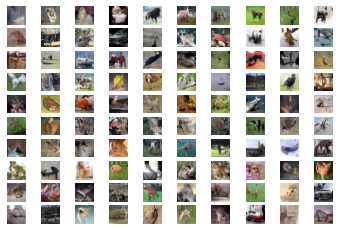

In [28]:
model = load_model('generator_model_100.h5')
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
create_plot(X, 10)